# Architecture Identification

Multi-class classification algorithm for different architectures.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.torch_imports import *

In [3]:
torch.cuda.set_device(0)

In [4]:
PATH = 'data/datasets/buildings/multi-class/'
sz = 299
arch = resnext101_64
bs = 58

In [5]:
label_csv = f'{PATH}shuffled.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

## 1  Exploring the data:

In [6]:
!ls {PATH}

csv_shuffler.py  filelists  labels.csv	shuffled.csv  test  tmp  train


In [7]:
label_df = pd.read_csv(label_csv)

In [8]:
label_df.head()

,id,style
0,717_450px-30_St_Mary_Axe%2C_%27Gherkin%27.JPG,international
1,2721_800px-Vitra_fire_station%2C_full_view%2C_...,deconstructivism
2,717_600px-11-07-31-helsinki-by-RalfR-135.jpg,russian_revival
3,2882_794px-Pla%C3%A7a_de_l%27Ajuntament_de_Val...,art_deco
4,6123_800px-Wroc%C5%82aw_-_Rynek_-_Kamienice.JPG,art_nouveau


In [9]:
label_df.pivot_table(index = 'style', aggfunc = len).sort_values('id', ascending = False)

,id
style,
art_nouveau,450
queen_anne,425
art_deco,366
greek_revival,327
ancient_egyptian,256
baroque,239
deconstructivism,213
novelty,212
international,207


In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, 
                                    val_idxs = val_idxs, suffix = '', tfms=tfms, bs=bs, num_workers=4)

In [11]:
# check if we got the path right
fn = PATH+data.trn_ds.fnames[0]; fn

'data/datasets/buildings/multi-class/train/717_450px-30_St_Mary_Axe%2C_%27Gherkin%27.JPG'

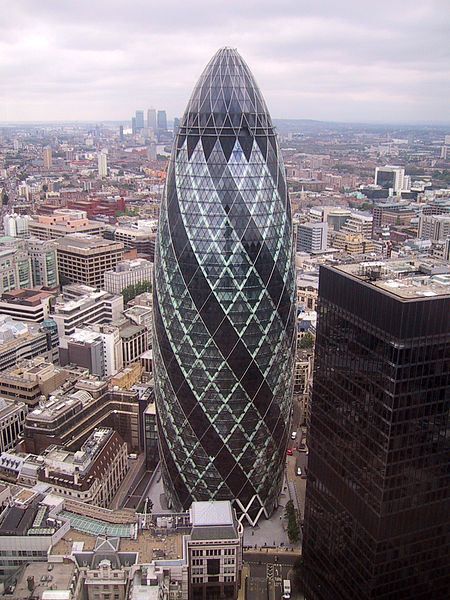

In [12]:
img = PIL.Image.open(fn); img

In [13]:
img.size

(450, 600)

In [14]:
# map the name of the file to the size of the file in a dictionary:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [15]:
row_sz, column_sz = list(zip(*size_d.values()))

In [16]:
row_sz = np.array(row_sz); column_sz = np.array(column_sz)

In [17]:
row_sz[:5]

array([450, 800, 600, 794, 800])

Visualize the sizes of the images:

(array([1028., 2708.,   19.,   24.,   16.,   13.,    9.,    3.,    9.,    6.]),
 array([ 203. ,  611.5, 1020. , 1428.5, 1837. , 2245.5, 2654. , 3062.5, 3471. , 3879.5, 4288. ]),
 <a list of 10 Patch objects>)

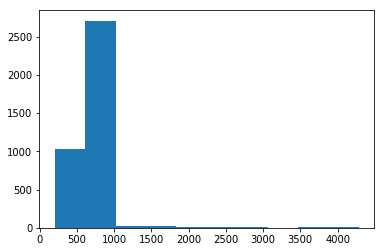

In [18]:
# we want to visualize the sizes of the images to get an idea
plt.hist(row_sz)

(array([   9.,   39.,  220.,  556.,  121.,  196.,  147.,  188., 2254.,    4.]),
 array([203. , 276.8, 350.6, 424.4, 498.2, 572. , 645.8, 719.6, 793.4, 867.2, 941. ]),
 <a list of 10 Patch objects>)

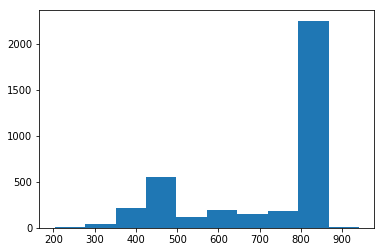

In [19]:
plt.hist(row_sz[row_sz<1000])

(array([ 995., 2726.,   26.,   10.,   16.,   19.,   19.,   19.,    0.,    5.]),
 array([ 152. ,  536.8,  921.6, 1306.4, 1691.2, 2076. , 2460.8, 2845.6, 3230.4, 3615.2, 4000. ]),
 <a list of 10 Patch objects>)

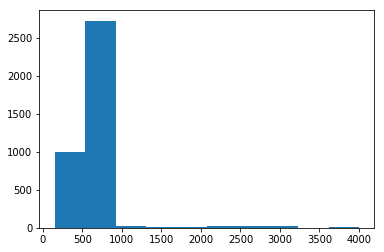

In [20]:
plt.hist(column_sz)

(array([  12.,   19.,   62.,  266.,  791., 2557.,    3.,   10.,    1.,    2.]),
 array([152. , 235.4, 318.8, 402.2, 485.6, 569. , 652.4, 735.8, 819.2, 902.6, 986. ]),
 <a list of 10 Patch objects>)

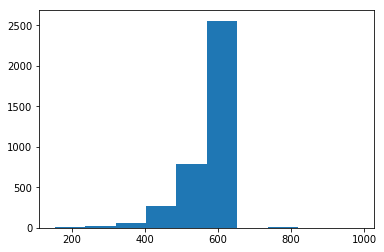

In [21]:
plt.hist(column_sz[column_sz<1000])

In [22]:
# show number of training images
len(data.trn_ds)

3835

In [23]:
# show number of breeds (classes) and a sample
len(data.classes), data.classes[:5]

(25,
 ['achaemenid',
  'american_craftsman',
  'american_foursquare',
  'ancient_egyptian',
  'art_deco'])

## 2 Model

In [30]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}shuffled.csv', num_workers = 4,
                                       val_idxs = val_idxs, tfms = tfms, bs = bs)
    return data if sz > 300 else data.resize(340, 'tmp')

### 3.1 Precomputation

In [31]:
data = get_data(sz, bs)

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [38]:
learn.fit(1e-2, 6)

epoch      trn_loss   val_loss   accuracy                 
    0      1.775865   1.125331   0.637787  
    1      1.272899   1.000146   0.676409                 
    2      1.065457   0.933027   0.706681                 
    3      0.942868   0.916686   0.708768                  
    4      0.815651   0.888343   0.73904                   
    5      0.707413   0.8492     0.742171                  



[array([0.8492]), 0.7421711955787245]

### 3.2 Augmentation

In [39]:
from sklearn import metrics

In [40]:
data = get_data(sz, bs)

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [42]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.829002   1.195008   0.64405   
    1      1.318181   1.02839    0.677453                 



[array([1.02839]), 0.6774530151940586]

Turning off precompute will result in our own training:

In [43]:
learn.precompute=False

In [44]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.133645   0.969005   0.695198  
    1      1.072079   0.92615    0.688935                 
    2      1.03775    0.90025    0.710856                 
    3      0.99905    0.868398   0.728601                  
    4      0.964086   0.843492   0.727557                  



[array([0.84349]), 0.7275574162509097]

In [34]:
learn.save('299_architectures_pre')

In [35]:
learn.load('299_architectures_pre')

### 3.3 Increasing the size

We want to increase the size of the images and continue training again.

In [36]:
sz = 340
learn.set_data(get_data(sz, bs))
learn.freeze()

In [37]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.94425    0.820899   0.736952  
    1      0.908565   0.816398   0.744259                  
    2      0.862835   0.789683   0.751566                  



[array([0.78968]), 0.7515657648661938]

Try test time augmentation to see if it's going to help:

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y), metrics.log_loss(y, probs)

(0.7526096033402923, 0.819020561261191)